In [ ]:
!pip install ta
!pip install pandas-ta
!pip install investpy

In [2]:
import pandas as pd
import numpy as np
import investpy
import seaborn as sns
from copy import copy
import matplotlib.pyplot as plt
import statistics as stats
import math
from ta.volume import MFIIndicator
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import random
import multiprocessing as mp

# Import périodes et mise en forme #

In [11]:
df_source = investpy.get_etf_historical_data(etf='Lyxor UCITS NASDAQ-100 Daily Leverage',
                                            country='France',
                                            from_date='01/10/2006',
                                            to_date='31/12/2011')

In [12]:
df_source.drop(columns=['Currency','Exchange'], inplace=True)

In [13]:
df_source.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [14]:
df_source.reset_index(inplace=True)

In [15]:
df_source.tail(1)

,Date,Open,High,Low,Close,Volume
1334,2011-12-30,24.07,24.07,23.9,23.94,32433


In [16]:
df_source_allTime = investpy.get_etf_historical_data(etf='Lyxor UCITS NASDAQ-100 Daily Leverage',
                                            country='France',
                                            from_date='01/10/2006',
                                            to_date='14/04/2022')

df_source_allTime.drop(columns=['Currency','Exchange'], inplace=True)
df_source_allTime.reset_index(inplace=True)
df_source_allTime.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [21]:
df_source_allTime.tail(1)

,Date,Open,High,Low,Close,Volume
3962,2022-04-14,724.3,726.8,708.0,711.3,3226


# Fonctions #

In [30]:
def get_min_max(col):
  ''' Obtenir le minimum et le 3e quartile de chaque colonne qui détermineront la plage d'entrées à explorer'''

  # Minimum 10e quantile
  m = round(col.quantile(.1), 0)

  # Maximum 90e quantile
  max = round(col.quantile(.9), 0)

  # On genere une liste par incrément de 1 entre les deux extremes
  l_mm = [x for x in range(int(m),int(max+1))]

  return l_mm

In [31]:
def find_entries(df_in, entree):
  ''' Obtenir les index des dates auxquelles le MFI franchit la limite d'entrée vers le haut '''

  df=df_in.copy()

  # Ajout de la colonne MFI de la veille
  shift = df[df.columns[-1]].shift(1)
  shift[0]=shift[1]
  df['MFI_lag']=shift

  entries_list = df.index[ (df[df.columns[-2]] > entree) & (df[df.columns[-1]] <= entree) ].to_list()

  return entries_list

In [32]:
def get_entries_list(mfi,entry):
  ''' Retourne les index des entrées identifiées dans la table df_ta_AT'''
  
  # Ajout de la colonne mfi_lag
  shift = df_ta_AT['MFI_'+str(mfi)].shift(1)
  shift[0]=shift[1]
  df_ta_AT['MFI_'+str(mfi)+'_lag']=shift

  entries_list = df_ta_AT.index[ (df_ta_AT['MFI_'+str(mfi)] > entry) & (df_ta_AT['MFI_'+str(mfi)+'_lag'] <= entry)].to_list()

  return entries_list

In [33]:
def fix_oob_index(a, limite):
  ''' Necessaire pour corriger si l'entrée est trop proche de notre date limite max.
  Doit préceder generate_future_dates en conséquence'''
  for element in range(0,len(a)):
    if a[element] > limite :
      a[element] = limite
  return a

In [34]:
def generate_future_dates(df, entries_list):
  '''Générer les dates futures après identification des entrées
  Puis calcul des variations'''

  arr_entries = np.asarray(entries_list)

  arr_e1s = arr_entries + 5
  arr_e2s = arr_entries + 10
  arr_e1m = arr_entries + 21
  
  # Aggregation des matrices sous forme de liste en vue de traitements en boucle
  dates_ech = [ arr_e1s, arr_e2s, arr_e1m]

  # On fixe le plus grand index possible, au cas où la projection 5, 10j ou 1 mois en avant soit out of bounds
  date_limite = df.shape[0]-1

  # Correction des éventuelles dates futures out of bounds, selon fonction définie précedemment
  for echeance in dates_ech:
    echeance = fix_oob_index(echeance,date_limite)

  # Conversion des index de array -> liste
  # Sélection du Close à la date correspondant à l'index
  s_1s = df.loc[list(arr_e1s),'Close'].to_list()
  s_2s = df.loc[list(arr_e2s),'Close'].to_list()
  s_1m = df.loc[list(arr_e1m),'Close'].to_list()

  # Création d'un dataframe d'entrée selon les index indentifiés
  df_res = df.filter(items = entries_list, axis=0)

  # Ajout des séries comme nouvelles colonnes
  df_res['Close_1s'] = s_1s
  df_res['Close_2s'] = s_2s
  df_res['Close_1m'] = s_1m

  df_res['var_1s'] = round( (df_res['Close_1s']-df_res['Close'])/df_res['Close'] ,2)
  df_res['var_2s'] = round( (df_res['Close_2s']-df_res['Close'])/df_res['Close'] ,2)
  df_res['var_1m'] = round( (df_res['Close_1m']-df_res['Close'])/df_res['Close'] ,2)

  # Suppression de la dernière ligne, car n'ayant pas abouti dans le temps, va fausser les résultats d'analyse
  df_res.drop(df_res.tail(1).index, inplace = True)

  # On ne conserve que les champs liés aux performances à échéance
  df_res = df_res[['Date','Close','var_1s','var_2s','var_1m']]
  df_res.reset_index(drop=True, inplace=True)

  return df_res

In [35]:
def get_ech_values(l):
  # Conversion en np array
  arr_e = np.asarray(l)

  # Génère les dates d'échéance
  arr_e2s = arr_e + 10
  arr_e1m = arr_e + 21
  # Aggregation des matrices sous forme de liste en vue de traitements en boucle
  dates_ech = [ arr_e2s, arr_e1m]

  # On fixe le plus grand index possible, au cas où la projection 10j ou 1 mois en avant soit out of bounds
  date_limite = df_ta_AT.shape[0]-1

  # Correction si les échéances de la dernière entrée dépassent la limite
  for echeances in dates_ech :
    fix_oob_index(echeances, date_limite)
  
  # Conversion des index de array -> liste
  # Puis aggregation du résultat
  s_2s = df_ta_AT.loc[list(arr_e2s),'Close'].to_list()
  s_1m = df_ta_AT.loc[list(arr_e1m),'Close'].to_list()

  # Création d'un dataframe d'entrée selon les index indentifiés
  df_res = df_ta_AT.filter(items = l, axis=0)

  # Ajout des séries comme nouvelles colonnes
  df_res['Close_2s'] = s_2s
  df_res['Close_1m'] = s_1m

  # Calcul des variations en % et ajout en tant que colonne
  df_res['var_2s'] = round( (df_res['Close_2s']-df_res['Close'])/df_res['Close'] ,2)
  df_res['var_1m'] = round( (df_res['Close_1m']-df_res['Close'])/df_res['Close'] ,2)

  # On ne conserve que les champs liés aux performances à échéance
  df_res = df_res[['Date','Close','var_2s','var_1m']]
  df_res.reset_index(drop=True, inplace=True)

  return df_res

In [36]:
def get_exits_list(df, el, tp, sl, p, s):
  ''' Liste des sorties combinant risk management, sortie optimale MFI, sur un DataFrame TA
  Ajouter la liste des entrées '''
  
  exits_list=[]
  
  for e in range (0, len(el)):
    # On isole l'index de la ligne d'entrée
    row_index = el[e]
    # Pointeur commence les vérifications à partir de la ligne suivante
    r = row_index+1
    # Indicateur qu'une limite a été trouvée ou la fin des données atteinte
    touch = False

    # Définition des limites
    limite = df.loc[row_index,'Close'] * tp
    stop_loss = df.loc[row_index,'Close'] * sl
    
    # Test si High, Low, ou Open touche l'une des limites. 
    # A priori, Close sera toujours le dernier à les toucher. 
    # Open dans le cas d'un gap à l'ouverture qui déclencherait l'une des limites.
    while(touch == False):  
      if( r >= df.shape[0]-1):
        exits_list.append(df.shape[0]-1)
        touch = True
      elif( 
          (df.loc[r,'Open'] >= limite) or 
          (df.loc[r,'High'] >= limite) or 
          (df.loc[r,'Open'] <= stop_loss) or 
          (df.loc[r,'Low'] <= stop_loss) or
          ( (df.loc[r,'MFI_'+str(p)] < s) & (df.loc[r,'MFI_'+str(p)+'_lag'] >= s) )
        ):
        exits_list.append(r)
        touch = True
      else:
        r+=1
    e+=1

  return exits_list

In [37]:
def calc_performance(df):
  ''' Calculer la performance cumulée en % à 1 mois '''

  # Calcul performance investissement initial
  perf_list=[1000]

  # Selection de la dernière colonne, variation à 1 mois
  perfs = df[df.columns[-1]].to_list()

  # Investissement de base, 1000
  invest = 1000

  # Calcul de la performance cumulée
  for i in range (0, df.shape[0]):
    invest = invest * (1 + perfs[i])
    perf_list.append(invest)

  # Equivalence en %
  perfP = round( ((perf_list[-1]-perf_list[0])/perf_list[0])*100 ,2)

  return perfP

In [38]:
def calc_WinLossRatio(df):
  ''' Obtention du nombre de trades positifs à 2 semaines (10j)'''
  compte = df.apply(lambda x : 
                          True if x['var_2s'] > 0 
                          else False, axis = 1)
  # Count number of True in the series
  wr_ratio = round( len(compte[compte == True].index) / df.shape[0], 2)
  return wr_ratio

In [39]:
def calc_profit_factors(df, WR):
  ''' Donne le profit factor classique et alternatif, sur la base du dataset df_perf et du Win Loss Ratio obtenu
  Profit factor classique = (Gross winning trades) / (Gross losing trades)
  Alternative = (Win Rate * Avg Win) / (Loss Rate * Avg Loss)'''
  pf=[]
  
  df_perf_pos = df.loc[ (df["var"] > 0) ]
  df_perf_pos["gain"] = 1000 * df_perf_pos["var"] 
  gross_gains = df_perf_pos["gain"].sum()

  df_perf_neg = df.loc[ (df["var"] <= 0) ]
  df_perf_neg["loss"] = 1000 * df_perf_neg["var"] 
  gross_losses = abs(df_perf_neg["loss"].sum())

  gross_profit_factor = round(gross_gains / gross_losses, 2)
  pf.append(gross_profit_factor)

  pfa_pos = df_perf_pos["var"].mean() * WR
  pfa_neg = ( abs(df_perf_neg["var"]).mean() ) * (1-WR)
  pfa = round(pfa_pos / pfa_neg, 2)
  pf.append(pfa)

  return pf

## Ajout Indicateurs Techniques ##

In [40]:
# Extrait des noms de colonnes, MFI_x uniquement
col_list = df_source.columns
col_list = col_list[6:]

In [41]:
df_ta = df_source.copy()

In [42]:
for i in range(5,56):
  s_mfi = MFIIndicator(high=df_source.High, low=df_source.Low, close=df_source.Close, volume=df_source.Volume, window=i).money_flow_index()
  df_ta['MFI_'+str(i)] = round(s_mfi, 2)
  p_max = i

In [43]:
# Démarrage lorsque tous les MFI sont renseignés
df_ta = df_ta.loc[(p_max-1):]
df_ta.reset_index(drop=True, inplace=True)

In [44]:
df_ta.head(1)

,Date,Open,High,Low,Close,Volume,MFI_5,MFI_6,MFI_7,MFI_8,...,MFI_46,MFI_47,MFI_48,MFI_49,MFI_50,MFI_51,MFI_52,MFI_53,MFI_54,MFI_55
0,2006-12-15,19.73,20.1,19.7,19.92,2397,90.73,82.52,69.76,65.58,...,62.07,63.25,62.53,62.99,63.72,64.24,64.63,64.63,64.59,64.59


In [45]:
'''Process identique pour allTime 
col_list est identique'''
df_ta_allTime = df_source_allTime.copy()

In [46]:
for i in range(5,71):
  s_mfi = MFIIndicator(high=df_source_allTime.High, low=df_source_allTime.Low, close=df_source_allTime.Close, volume=df_source_allTime.Volume, window=i).money_flow_index()
  df_ta_allTime['MFI_'+str(i)] = round(s_mfi, 2)
  p_max = i

In [47]:
# Démarrage lorsque tous les MFI sont renseignés
df_ta_allTime = df_ta_allTime.loc[(p_max-1):]
df_ta_allTime.reset_index(drop=True, inplace=True)

In [48]:
df_ta_allTime.head(1)

,Date,Open,High,Low,Close,Volume,MFI_5,MFI_6,MFI_7,MFI_8,...,MFI_61,MFI_62,MFI_63,MFI_64,MFI_65,MFI_66,MFI_67,MFI_68,MFI_69,MFI_70
0,2007-01-10,19.13,19.55,19.07,19.55,522,78.8,80.75,82.44,85.18,...,47.74,48.72,48.39,48.78,49.39,49.84,50.18,50.18,50.16,50.16


# Application sur la totalité des entrées #

## Generation des tables WR, Nb trades et Perf +21j ##

### Période 2006-2011 ###

In [ ]:
bh = ((df_source['Close'].iloc[-1] - df_source['Close'].iloc[0])/df_source['Close'].iloc[0])*100
print("Buy & Hold : {:.2f} %".format(bh))

Buy & Hold : 37.27 %


In [ ]:
# Creation du dataframe souce, avec index 0 à 100
l_index = [x for x in range(0,101)]

# Creation des Dataframe initiaux
df_perf21j = pd.DataFrame(index = l_index)
df_WLratio21j = pd.DataFrame(index = l_index)
df_nbTrades21j = pd.DataFrame(index = l_index)

In [ ]:
# MFI_5 commence à la colonne N°6. Jusqu'à la dernière colonne MFI. 
for c in range(6, df_ta.shape[1]):

  # Dictionnaire pour le recueil de performance, 1 colonne, toutes entrées possibles
  d_perf = {}
  d_wr = {}
  d_nb_trades = {}

  # Obtention de la liste des entrées possibles, selon bornes min et max de la plage de données
  l_minMAX = get_min_max(df_ta.iloc[:,c])

  for entree in l_minMAX:

    ''' Trouver les dates correspondant au croisement vers le haut de l'entrée selectionnée
    Attention la liste fonctionne par exclusion du nombre max.
    Pour MFI 5 c'est donc bien de la colonne 0 à 6'''
    l_e = find_entries(df_ta[df_ta.columns[0:c+1]], entree)

    # Ajout des performances à +5, +10 et +21j
    df_dates = generate_future_dates(df_ta[df_ta.columns[0:c+1]], l_e)
    
    # Obtention de la performance à +21j
    p = calc_performance(df_dates)
    # Ajout du résultat au dictionnaire, paire entrée:performance
    d_perf.update( {int(entree): p} )

    # Obtention du ratio Win/Loss
    wl_ratio = calc_WinLossRatio(df_dates)
    d_wr.update( {int(entree): wl_ratio} )

    # Obtention du nb de trades
    nb_t = df_dates.shape[0]
    d_nb_trades.update( {int(entree): nb_t} )

  '''Fin du calcul des entrées par colonnes'''
  df_column_performance = pd.DataFrame.from_dict(d_perf, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  df_wl = pd.DataFrame.from_dict(d_wr, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  df_nbT = pd.DataFrame.from_dict(d_nb_trades, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  # Jointure du dataframe obtenu des performances de la colonne sur l'origine
  df_perf21j = df_perf21j.join(df_column_performance)
  df_WLratio21j = df_WLratio21j.join(df_wl)
  df_nbTrades21j = df_nbTrades21j.join(df_nbT)

#### Mise en correspondance, meilleur WR avec Nb Trades et perf ####

In [ ]:
''' Process avec le Win Ratio en principal '''
# Obtenir l'index de la meilleure entrée pour chaque colonne (MFI)
maxValueIndex = df_WLratio21j.idxmax()
df_best_WR_Index = pd.DataFrame(maxValueIndex, columns=["best_WR_entry"])

In [ ]:
d_maxValues = {}
# On se base sur les meilleures entrées par colonne pour trouver la performance correspondante
for i in range(0,len(maxValueIndex)):
  d_maxValues.update( {"MFI_"+str(i+5): df_WLratio21j.at[maxValueIndex[i],'MFI_'+str(i+5)]} )

# Passage du dictionnaire de résultat en Dataframe
# Ici ce sont les colonnes qui sont en index pour être conformes au Dataframe best_index avant jointure
df_MaxWR = pd.DataFrame.from_dict(d_maxValues, orient='index',
                      columns=["best_WR"])

In [ ]:
# Jointure entre les meilleures perfs par colonnes et leurs entrées correspondantes
df_MaxWR = df_MaxWR.join(df_best_WR_Index)
df_MaxWR.sort_values(by=["best_WR"], ascending=False, inplace=True)

In [ ]:
''' Agrégation avec le nombre de trades '''
# Obtention des index MFI sous forme de liste
l_index = df_MaxWR.index.values.tolist()
l_entry = df_MaxWR['best_WR_entry'].to_list()

In [ ]:
d_get_NbT_Values = {}
for i in range(0, len(l_index)):
  e = l_entry[i]
  m = l_index[i]

  res = df_nbTrades21j.at[e,m]

  d_get_NbT_Values.update( {m: res} )

In [ ]:
df_join_NbT = pd.DataFrame.from_dict(d_get_NbT_Values, orient='index',
                      columns=["nb_trades"])
df_join_NbT = df_join_NbT["nb_trades"].astype(int)

In [ ]:
df_MaxWR = df_MaxWR.join(df_join_NbT)

In [ ]:
''' Agrégation avec la performance accumulée, sortie fixe à +21 jours '''
d_get_perf = {}
for i in range(0, len(l_index)):
  e = l_entry[i]
  m = l_index[i]

  res = df_perf21j.at[e,m]

  d_get_perf.update( {m: res} )

In [ ]:
df_join_perf = pd.DataFrame.from_dict(d_get_perf, orient='index',
                      columns=["perf_21j"])
df_join_perf = df_join_perf["perf_21j"].astype(int)

In [ ]:
df_MaxWR = df_MaxWR.join(df_join_perf)

In [ ]:
df_MaxWR[["best_WR_entry","best_WR","nb_trades","perf_21j"]]

,best_WR_entry,best_WR,nb_trades,perf_21j
MFI_45,43,0.83,18,179
MFI_47,41,0.83,18,222
MFI_51,58,0.82,22,370
MFI_49,65,0.82,17,104
MFI_48,41,0.80,20,208
MFI_44,43,0.78,23,208
MFI_26,62,0.78,32,123
MFI_46,45,0.78,23,217
MFI_25,60,0.76,33,164
MFI_55,60,0.75,16,95


#### Visualisations ####

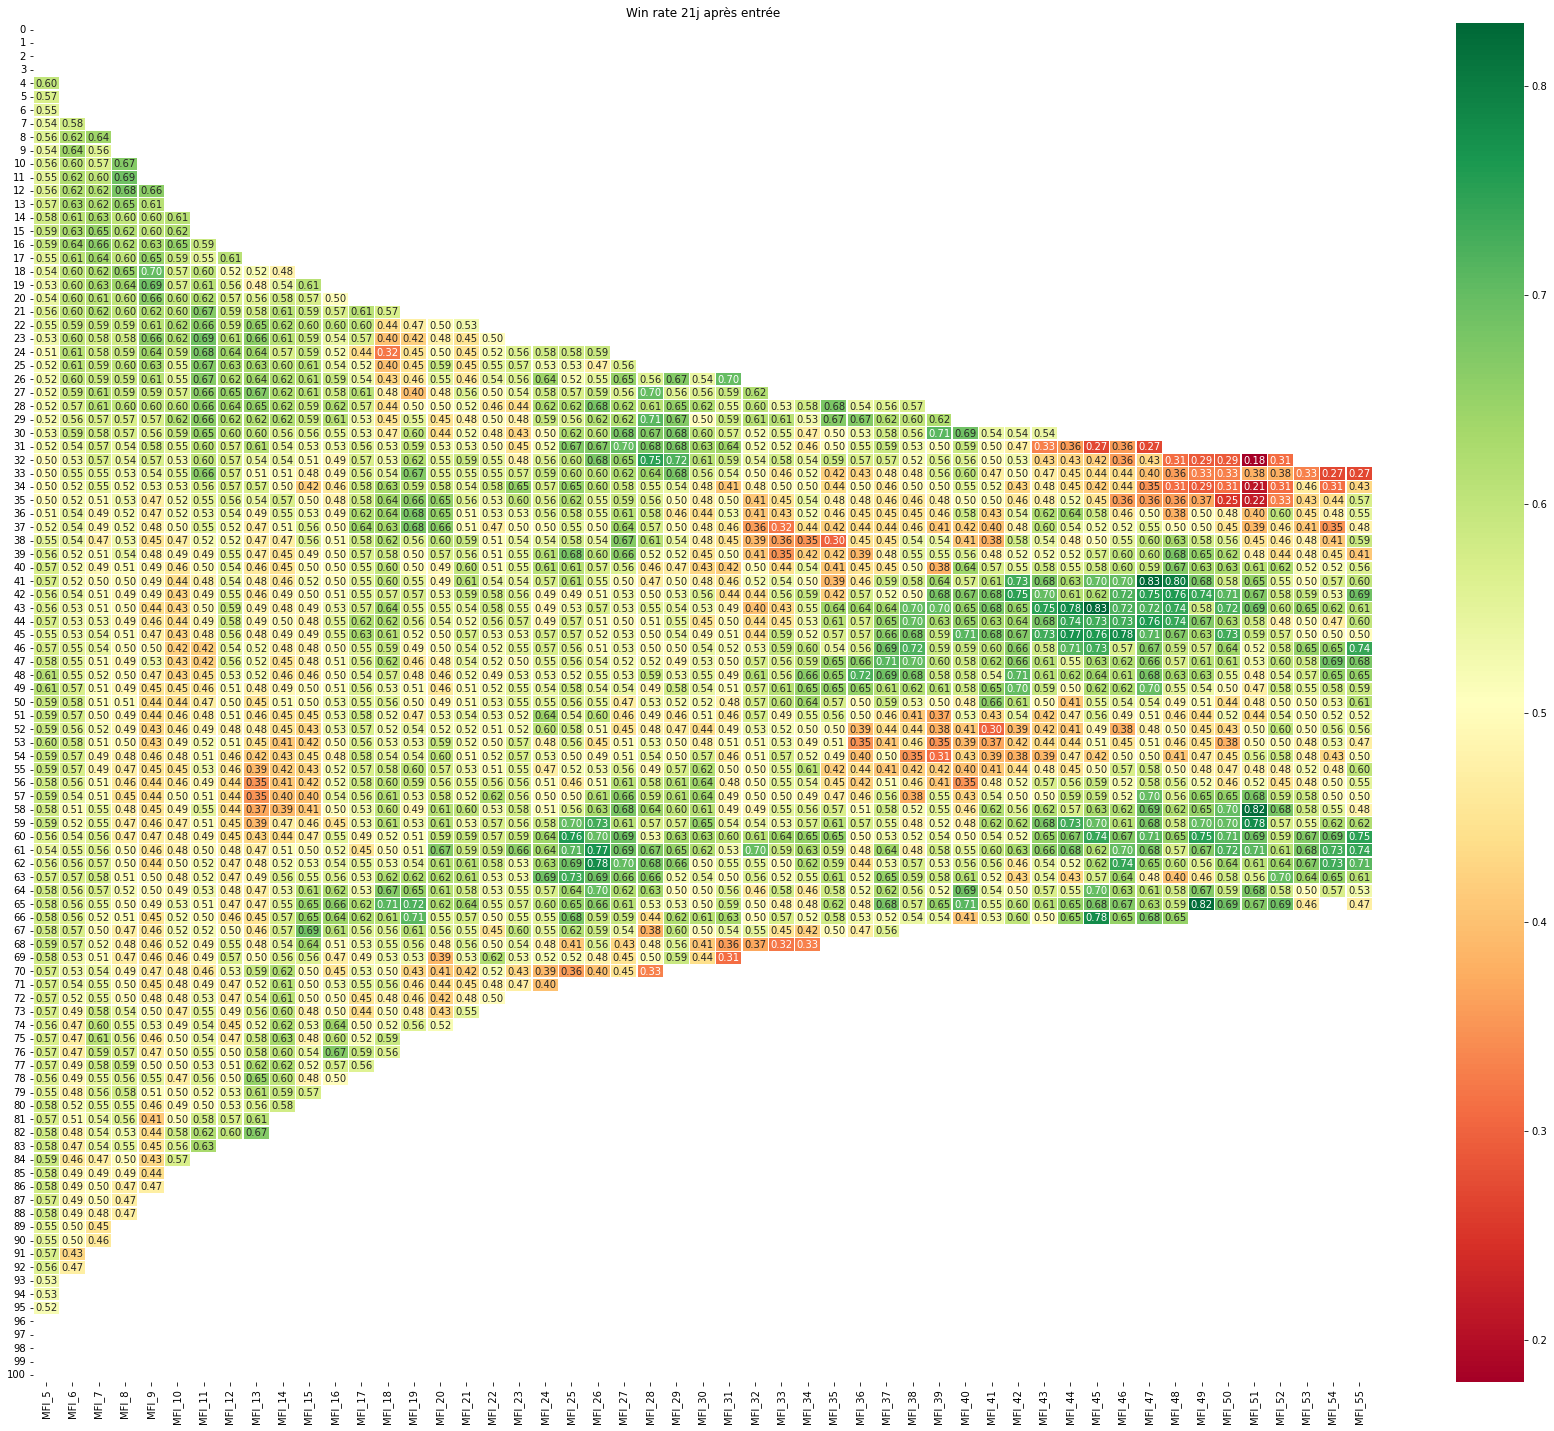

In [ ]:
fig, ax = plt.subplots(figsize = (30, 25))
sns.heatmap( df_WLratio21j, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt=".2f")
ax.set_title("Win rate 21j après entrée")
chemin = "MFI_long_entries_study_2006-2011_21j.png"
plt.savefig(chemin)

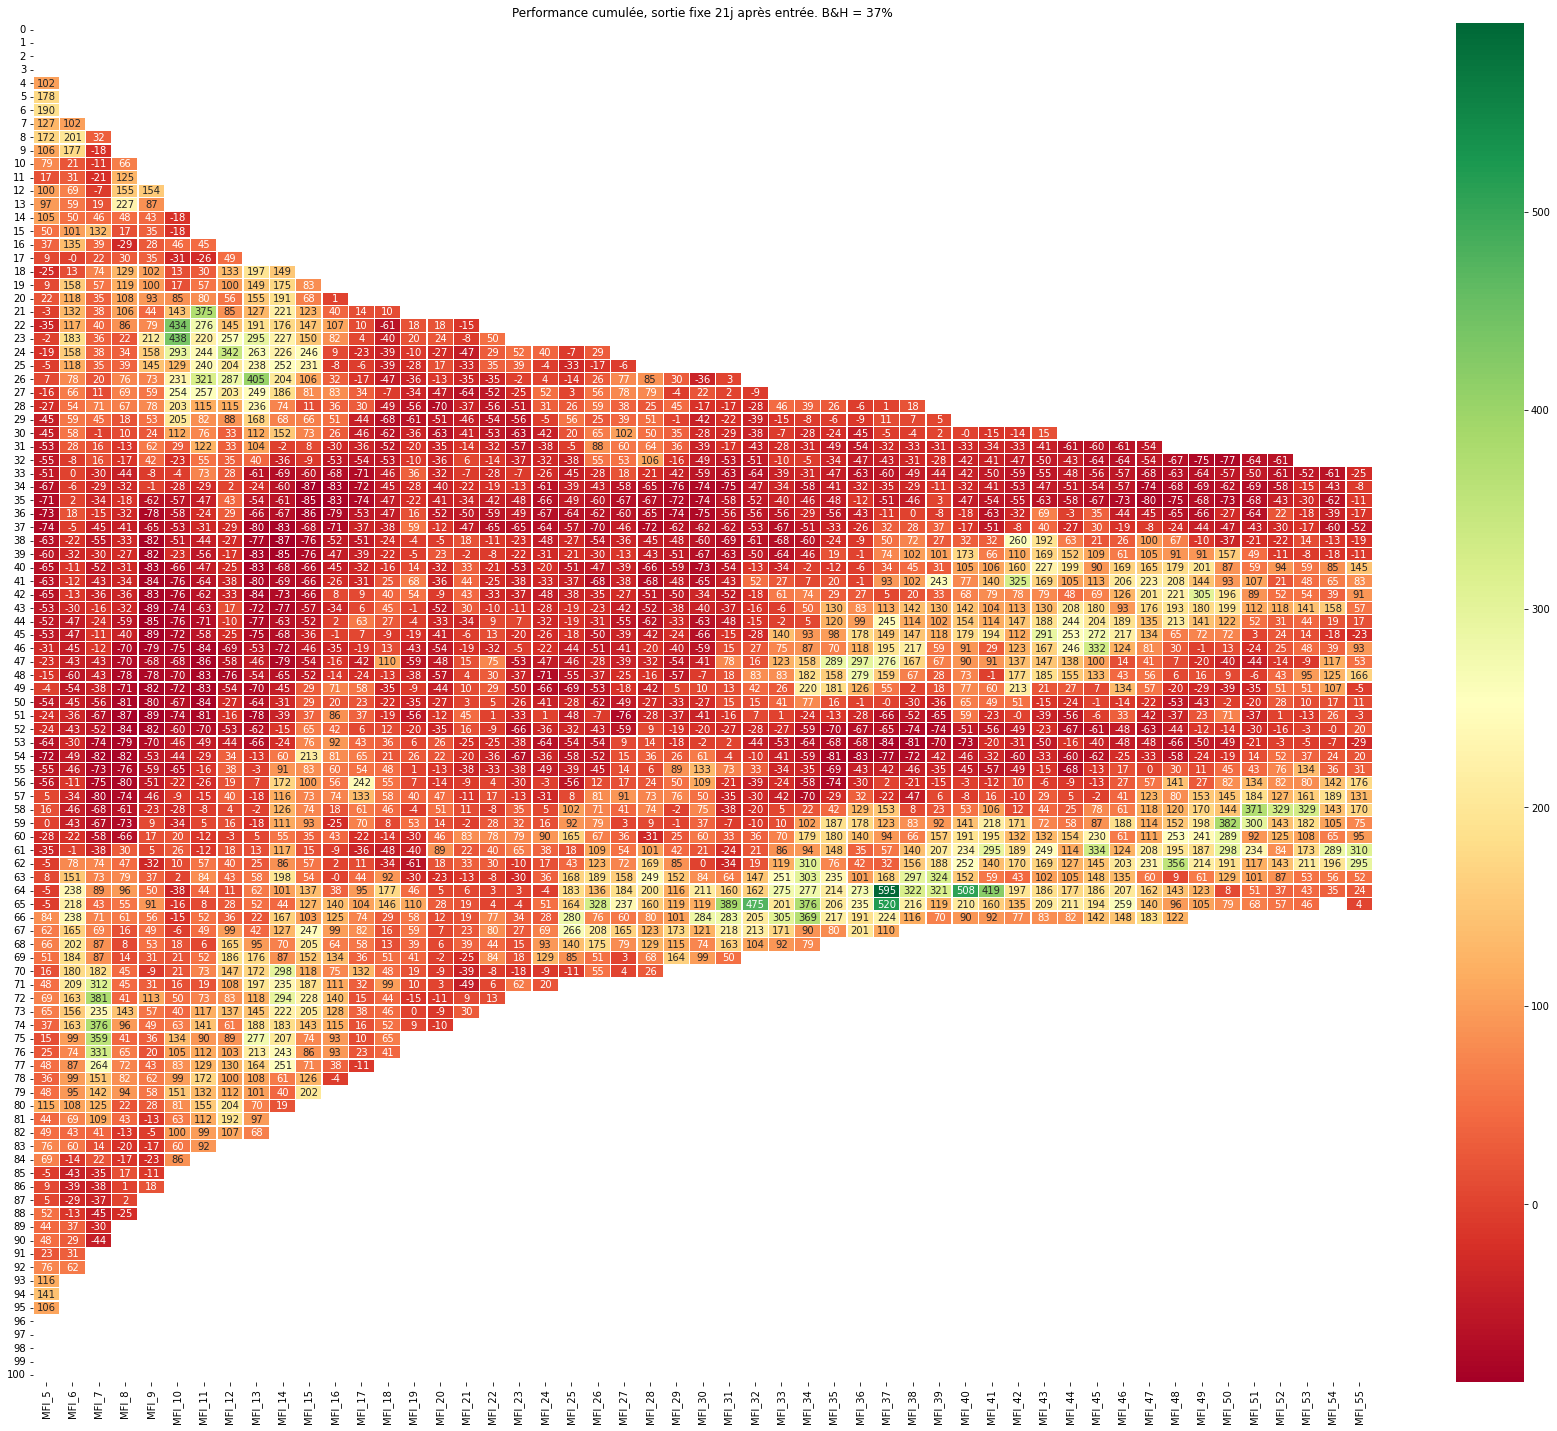

In [ ]:
fig, ax = plt.subplots(figsize = (30, 25))
sns.heatmap( df_perf21j, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt=".0f")
ax.set_title("Performance cumulée, sortie fixe 21j après entrée. B&H = 37%")
chemin = "MFI_long_entries_study_2006-2011_21j.png"
plt.savefig(chemin)

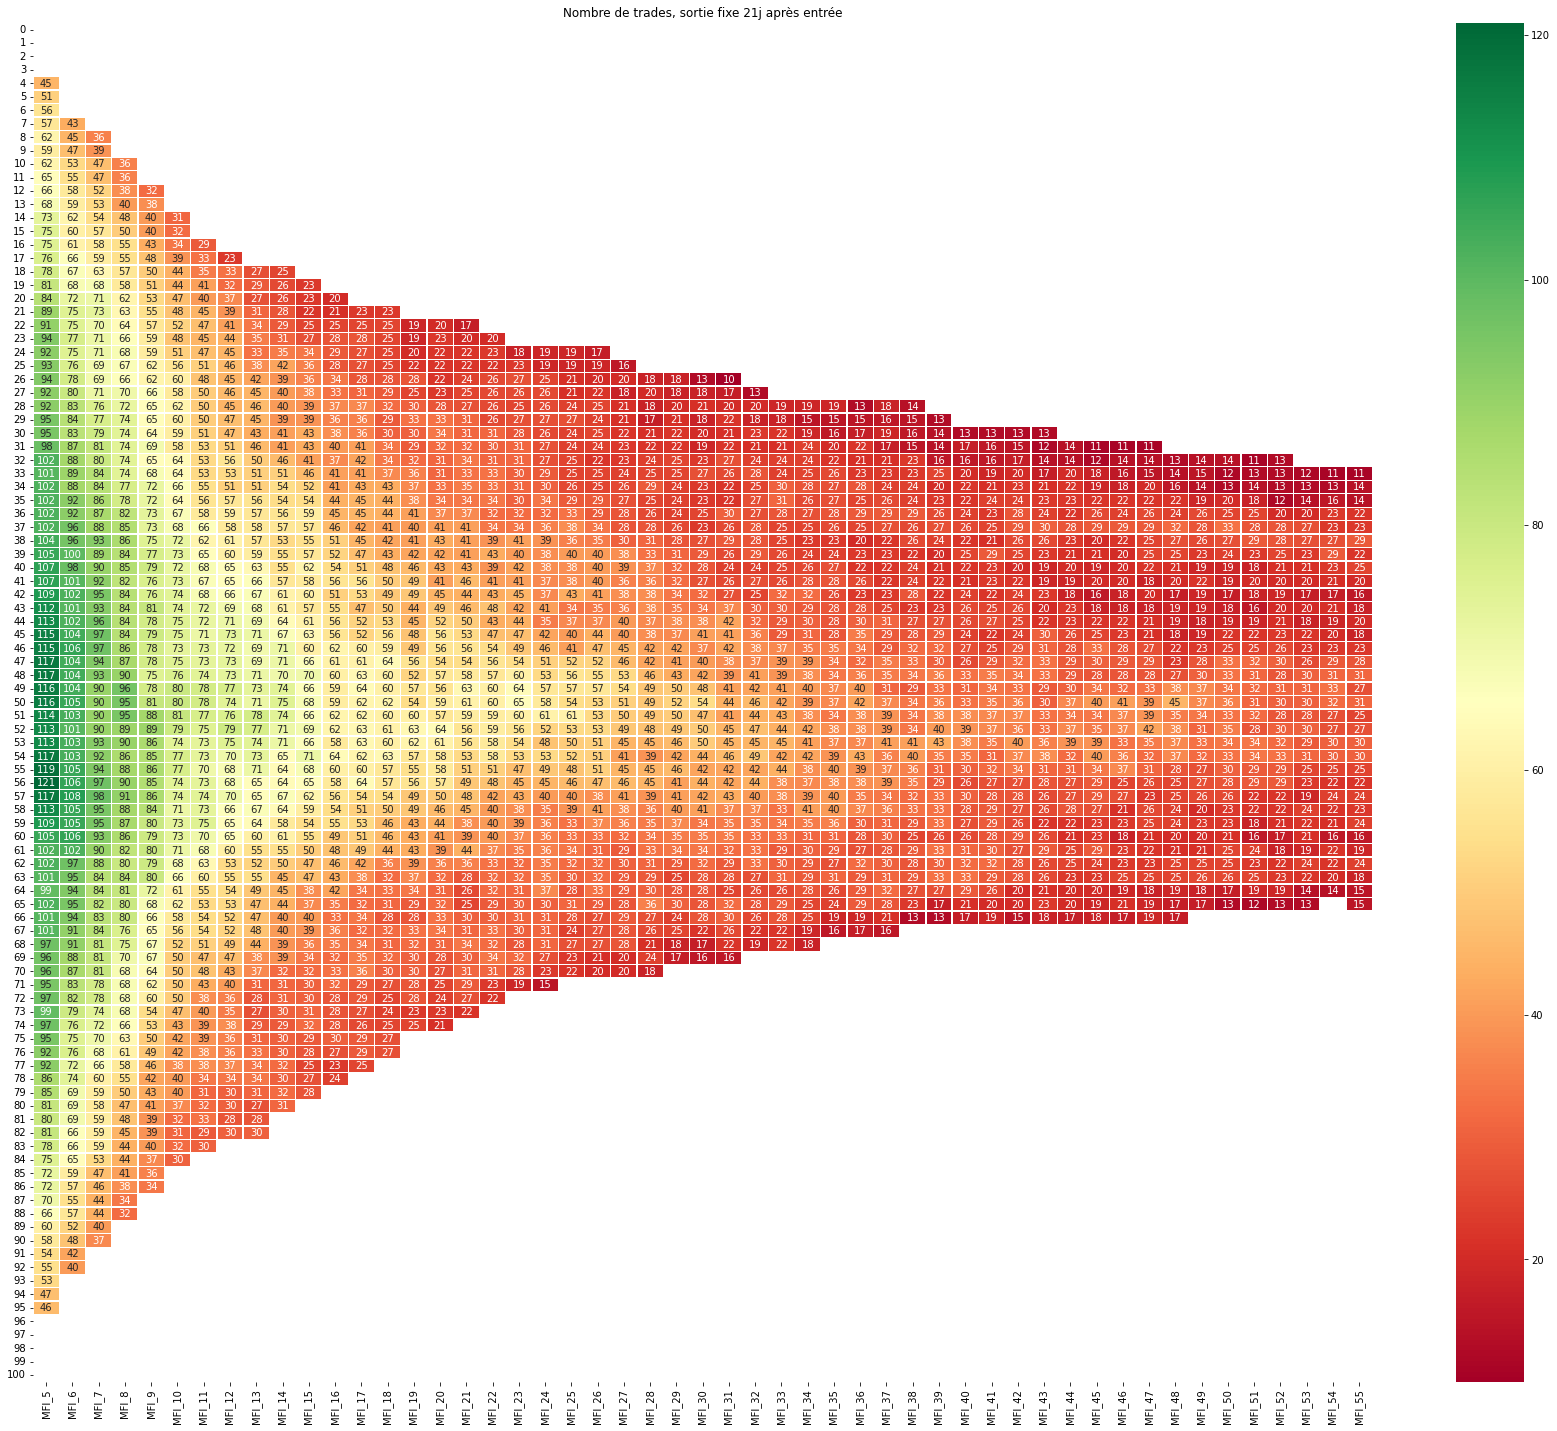

In [ ]:
fig, ax = plt.subplots(figsize = (30, 25))
sns.heatmap( df_nbTrades21j, cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt=".0f")
ax.set_title("Nombre de trades, sortie fixe 21j après entrée")
chemin = "MFI_long_entries_study_2006-2011_21j.png"
plt.savefig(chemin)

### Période 2006 - aujourd'hui ###

In [49]:
bh_AT = ((df_source_allTime['Close'].iloc[-1] - df_source_allTime['Close'].iloc[0])/df_source_allTime['Close'].iloc[0])*100
print("Buy & Hold : {:.2f} %".format(bh_AT))

Buy & Hold : 3978.56 %


In [50]:
# Creation du dataframe souce, avec index 0 à 100
l_index = [x for x in range(0,101)]

# Creation des Dataframe initiaux
df_perf21j = pd.DataFrame(index = l_index)
df_WLratio21j = pd.DataFrame(index = l_index)
df_nbTrades21j = pd.DataFrame(index = l_index)

In [51]:
df_ta_allTime[df_ta_allTime.columns[0:8]]

,Date,Open,High,Low,Close,Volume,MFI_5,MFI_6
0,2007-01-10,19.13,19.55,19.07,19.55,522,78.80,80.75
1,2007-01-11,19.98,20.69,19.98,20.57,6321,95.86,89.23
2,2007-01-12,20.35,20.62,20.35,20.62,7334,96.76,97.44
3,2007-01-15,20.73,20.86,20.69,20.76,16970,98.44,98.48
4,2007-01-16,20.66,20.70,20.50,20.56,1385,94.24,94.29
...,...,...,...,...,...,...,...,...
3889,2022-04-08,762.80,766.90,735.60,744.60,4276,44.40,36.92
3890,2022-04-11,726.10,729.60,703.00,708.30,7556,27.11,34.80
3891,2022-04-12,698.00,726.70,693.50,720.10,7993,12.73,21.59
3892,2022-04-13,707.90,717.80,695.80,717.80,7086,13.79,10.61


In [ ]:
# MFI_5 commence à la colonne N°6. Jusqu'à la dernière colonne MFI. 
for c in range(6, df_ta_allTime.shape[1]):

  # Dictionnaire pour le recueil de performance, 1 colonne, toutes entrées possibles
  d_perf = {}
  d_wr = {}
  d_nb_trades = {}

  # Obtention de la liste des entrées possibles, selon bornes min et max de la plage de données
  l_minMAX = get_min_max(df_ta_allTime.iloc[:,c])

  for entree in l_minMAX:

    ''' Trouver les dates correspondant au croisement vers le haut de l'entrée selectionnée
    Attention la liste fonctionne par exclusion du nombre max.
    Pour MFI 5 c'est donc bien de la colonne 0 à 6'''
    l_e = find_entries(df_ta_allTime[df_ta_allTime.columns[0:c+1]], entree)

    # Ajout des performances à +5, +10 et +21j
    df_dates = generate_future_dates(df_ta_allTime[df_ta_allTime.columns[0:c+1]], l_e)
    
    # Obtention de la performance à +21j
    p = calc_performance(df_dates)
    # Ajout du résultat au dictionnaire, paire entrée:performance
    d_perf.update( {int(entree): p} )

    # Obtention du ratio Win/Loss
    wl_ratio = calc_WinLossRatio(df_dates)
    d_wr.update( {int(entree): wl_ratio} )

    # Obtention du nb de trades
    nb_t = df_dates.shape[0]
    d_nb_trades.update( {int(entree): nb_t} )

  '''Fin du calcul des entrées par colonnes'''
  df_column_performance = pd.DataFrame.from_dict(d_perf, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  df_wl = pd.DataFrame.from_dict(d_wr, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  df_nbT = pd.DataFrame.from_dict(d_nb_trades, orient='index',
                      columns=['MFI_'+str(c-1)])
  
  # Jointure du dataframe obtenu des performances de la colonne sur l'origine
  df_perf21j = df_perf21j.join(df_column_performance)
  df_WLratio21j = df_WLratio21j.join(df_wl)
  df_nbTrades21j = df_nbTrades21j.join(df_nbT)

In [116]:
l_e = find_entries(df_ta_allTime[df_ta_allTime.columns[0:7]], 30)

# Ajout des performances à +5, +10 et +21j
df_dates = generate_future_dates(df_ta_allTime[df_ta_allTime.columns[0:7]], l_e)

In [117]:
df_dates

,Date,Close,var_1s,var_2s,var_1m
0,2007-02-02,19.49,0.01,0.01,-0.10
1,2007-02-15,19.64,0.02,-0.07,-0.10
2,2007-03-08,18.34,-0.02,0.03,0.02
3,2007-03-21,18.25,0.01,0.03,0.06
4,2007-04-05,18.66,0.02,0.04,0.08
...,...,...,...,...,...
271,2022-02-17,719.20,-0.10,-0.02,0.00
272,2022-02-21,661.40,0.08,0.01,0.14
273,2022-02-25,697.60,-0.02,-0.07,0.11
274,2022-03-09,657.70,0.03,0.15,0.12


In [118]:
def kill_multiple_entries(df):
  ''' Dédoublonnage itératif, adapté à sortie fixe + 21j'''

  # Obtention des index où les entrées chevauchent à une même date de sortie
  j=1
  last_row = df.shape[0]
  while j <= last_row:
    while ((df["Date"][j] - df["Date"][j-1]).days < 21):
      df.drop(index=j, inplace=True)
      df.reset_index(drop=True, inplace=True)
    last_row = df.shape[0]-1
    j+=1

In [119]:
kill_multiple_entries(df_dates)

In [120]:
df_dates

,Date,Close,var_1s,var_2s,var_1m
0,2007-02-02,19.49,0.01,0.01,-0.10
1,2007-03-08,18.34,-0.02,0.03,0.02
2,2007-04-05,18.66,0.02,0.04,0.08
3,2007-05-23,20.81,0.02,-0.00,0.02
4,2007-06-18,21.53,-0.01,-0.03,0.05
...,...,...,...,...,...
152,2021-11-15,921.60,0.07,0.03,-0.04
153,2021-12-07,947.00,-0.06,-0.07,-0.03
154,2022-01-12,883.00,-0.09,-0.17,-0.14
155,2022-02-17,719.20,-0.10,-0.02,0.00


#### Mise en correspondance, meilleur WR avec Nb Trades et perf ####

In [ ]:
''' Process avec le Win Ratio en principal '''
# Obtenir l'index de la meilleure entrée pour chaque colonne (MFI)
maxValueIndex = df_WLratio21j.idxmax()
df_best_WR_Index = pd.DataFrame(maxValueIndex, columns=["best_WR_entry"])

In [ ]:
d_maxValues = {}
# On se base sur les meilleures entrées par colonne pour trouver la performance correspondante
for i in range(0,len(maxValueIndex)):
  d_maxValues.update( {"MFI_"+str(i+5): df_WLratio21j.at[maxValueIndex[i],'MFI_'+str(i+5)]} )

# Passage du dictionnaire de résultat en Dataframe
# Ici ce sont les colonnes qui sont en index pour être conformes au Dataframe best_index avant jointure
df_MaxWR = pd.DataFrame.from_dict(d_maxValues, orient='index',
                      columns=["best_WR"])

In [ ]:
# Jointure entre les meilleures perfs par colonnes et leurs entrées correspondantes
df_MaxWR = df_MaxWR.join(df_best_WR_Index)
df_MaxWR.sort_values(by=["best_WR"], ascending=False, inplace=True)

In [ ]:
''' Agrégation avec le nombre de trades '''
# Obtention des index MFI sous forme de liste
l_index = df_MaxWR.index.values.tolist()
l_entry = df_MaxWR['best_WR_entry'].to_list()

In [ ]:
d_get_NbT_Values = {}
for i in range(0, len(l_index)):
  e = l_entry[i]
  m = l_index[i]

  res = df_nbTrades21j.at[e,m]

  d_get_NbT_Values.update( {m: res} )

In [ ]:
df_join_NbT = pd.DataFrame.from_dict(d_get_NbT_Values, orient='index',
                      columns=["nb_trades"])
df_join_NbT = df_join_NbT["nb_trades"].astype(int)

In [ ]:
df_MaxWR = df_MaxWR.join(df_join_NbT)

In [ ]:
''' Agrégation avec la performance accumulée, sortie fixe à +21 jours '''
d_get_perf = {}
for i in range(0, len(l_index)):
  e = l_entry[i]
  m = l_index[i]

  res = df_perf21j.at[e,m]

  d_get_perf.update( {m: res} )

In [ ]:
df_join_perf = pd.DataFrame.from_dict(d_get_perf, orient='index',
                      columns=["perf_21j"])
df_join_perf = df_join_perf["perf_21j"].astype(int)

In [ ]:
df_MaxWR = df_MaxWR.join(df_join_perf)

In [ ]:
df_MaxWR[["best_WR_entry","best_WR","nb_trades","perf_21j"]]

,best_WR_entry,best_WR,nb_trades,perf_21j
MFI_45,43,0.83,18,179
MFI_47,41,0.83,18,222
MFI_51,58,0.82,22,370
MFI_49,65,0.82,17,104
MFI_48,41,0.80,20,208
MFI_44,43,0.78,23,208
MFI_26,62,0.78,32,123
MFI_46,45,0.78,23,217
MFI_25,60,0.76,33,164
MFI_55,60,0.75,16,95


# Evaluation de la performance avec Risk Management #

## Reconstruction de 2006 à  aujourd'hui + indicateur technique ##

In [ ]:
# Definition des meilleures valeurs à tester
best_performers = {
    "MFI":[51,25,45,47,28,17],
    "entree":[58,60,43,41,32,38]
}

In [ ]:
df_ta_AT = df_source_allTime.copy()

for i in range(0,6):
  s_mfi = MFIIndicator(high=df_source_allTime.High, low=df_source_allTime.Low, close=df_source_allTime.Close, volume=df_source_allTime.Volume, window=best_performers["MFI"][i]).money_flow_index()
  df_ta_AT['MFI_'+str(best_performers["MFI"][i])] = round(s_mfi, 2)

In [ ]:
# Ajout de la colonne MFI 17 qui sera exploitée pour la sortie
s_mfi = MFIIndicator(high=df_source_allTime.High, low=df_source_allTime.Low, close=df_source_allTime.Close, volume=df_source_allTime.Volume, window=17).money_flow_index()
df_ta_AT['MFI_17'] = round(s_mfi, 2)
 # Ajout de la colonne mfi_lag
shift = df_ta_AT['MFI_17'].shift(1)
shift[0]=shift[1]
df_ta_AT['MFI_17_lag']=shift

In [ ]:
# Valeur max du MFI, en vue amputation lignes vides après  
p_max = max(best_performers["MFI"])

# Démarrage lorsque tous les MFI sont renseignés
df_ta_AT = df_ta_AT.loc[(p_max-1):]
df_ta_AT.reset_index(drop=True, inplace=True)

In [ ]:
# On conserve Low & High au cas où l'un touchera les limites de sortie avant la cloture
df_ta_AT.drop(columns=['Volume'], inplace=True)

### Liste des entrées et tableaux de variation à +10 et +21j ###

In [ ]:
def get_entries_list(mfi,entry):
  ''' Retourne les index des entrées identifiées dans la table df_ta_AT'''
  
  # Ajout de la colonne mfi_lag
  shift = df_ta_AT['MFI_'+str(mfi)].shift(1)
  shift[0]=shift[1]
  df_ta_AT['MFI_'+str(mfi)+'_lag']=shift

  entries_list = df_ta_AT.index[ (df_ta_AT['MFI_'+str(mfi)] > entry) & (df_ta_AT['MFI_'+str(mfi)+'_lag'] <= entry)].to_list()

  return entries_list

In [ ]:
# Les datasets de résultats seront intégrés dans une liste
list_df_res = []

for i in range (0, len(best_performers["MFI"])):  

  # Obtention de la liste d'entrées pour toutes les combinaisons du dictionnaire Best Performers
  liste_entrees = get_entries_list(best_performers["MFI"][i], best_performers["entree"][i])

  # Dataset résultat avec variations à +10 et +21j
  list_df_res.append(get_ech_values(liste_entrees))

In [ ]:
list_df_res[0].tail(1)

,Date,Close,var_2s,var_1m
92,2021-12-28,963.9,-0.1,-0.24


## Analyse Stat des meilleures entrées ##

In [ ]:
fig = go.Figure()
# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(x=list_df_res[0]['var_2s'], name="MFI_"+str(best_performers["MFI"][0])+'_e'+str(best_performers["entree"][0]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[1]['var_2s'], name="MFI_"+str(best_performers["MFI"][1])+'_e'+str(best_performers["entree"][1]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[2]['var_2s'], name="MFI_"+str(best_performers["MFI"][2])+'_e'+str(best_performers["entree"][2]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[3]['var_2s'], name="MFI_"+str(best_performers["MFI"][3])+'_e'+str(best_performers["entree"][3]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[4]['var_2s'], name="MFI_"+str(best_performers["MFI"][4])+'_e'+str(best_performers["entree"][4]), quartilemethod="inclusive"))
fig.show()

In [ ]:
fig = go.Figure()
# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(x=list_df_res[0]['var_1m'], name="MFI_"+str(best_performers["MFI"][0])+'_e'+str(best_performers["entree"][0]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[1]['var_1m'], name="MFI_"+str(best_performers["MFI"][1])+'_e'+str(best_performers["entree"][1]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[2]['var_1m'], name="MFI_"+str(best_performers["MFI"][2])+'_e'+str(best_performers["entree"][2]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[3]['var_1m'], name="MFI_"+str(best_performers["MFI"][3])+'_e'+str(best_performers["entree"][3]), quartilemethod="inclusive"))
fig.add_trace(go.Box(x=list_df_res[4]['var_1m'], name="MFI_"+str(best_performers["MFI"][4])+'_e'+str(best_performers["entree"][4]), quartilemethod="inclusive"))
fig.show()

In [ ]:
wr_ratio_AT = {}

for i in range(0,len(list_df_res)):
  wr_ratio_AT[ str(best_performers["MFI"][i])+'_e'+str(best_performers["entree"][i]) ] = calc_WinLossRatio(list_df_res[i])

wr_ratio_AT 

{'17_e38': 0.52,
 '25_e60': 0.63,
 '28_e32': 0.81,
 '45_e43': 0.7,
 '47_e41': 0.73,
 '51_e58': 0.67}

#### A faire  ####
<li>Analyse différenciée : Positifs Vs Négatifs</li>

## Etude des sorties ##

### Risk Management + MFI exit ###

In [ ]:
# Définition du ratio : Take Profit / Stop Loss
take_profit_factor = 1.3
stop_loss_factor = 0.85
# Défintion meilleur MFI sortie supposé
periode = 17
sortie = 87

In [ ]:
# Definition des meilleures valeurs à tester
d_combo_entry = {
    "MFI":[47,28,17],
    "entree":[41,32,38]
}

In [ ]:
# Combinaison des entrées des deux meilleurs MFI, période moyenne et période longue
liste_entrees = []

#for i in range (0, len(d_combo_entry["MFI"])):  
for i in range (0, 3):  

  # Obtention de la liste d'entrées
  l = get_entries_list(d_combo_entry["MFI"][i], d_combo_entry["entree"][i])
  liste_entrees = liste_entrees + l

# Remise des index par ordre chronologique, après concaténation des listes d'entrées
liste_entrees.sort()

In [ ]:
liste_sorties = get_exits_list(df_ta_AT, liste_entrees, take_profit_factor, stop_loss_factor, periode, sortie)

In [ ]:
if len(liste_sorties) == len(liste_entrees):
  print('ok')
else:
  print('mon vier')

ok


In [ ]:
# Préparation au merge des entrées et sorties dans un seul et même DataFrame
df_entries = df_ta_AT.filter(items = liste_entrees, axis=0)
df_entries = df_entries[['Date','Close']]
df_entries.reset_index(drop=True, inplace=True)

df_exits = df_ta_AT.filter(items = liste_sorties, axis=0)
df_exits = df_exits[['Date','Close']]
df_exits.reset_index(drop=True, inplace=True)

In [ ]:
# Jointure sur index réinitialisé
df_perf = df_entries.join(df_exits, lsuffix='_entry', rsuffix='_exit')
df_perf = df_perf[['Date_entry','Date_exit','Close_entry','Close_exit']]
# Variation positions Long
df_perf['var']= round( (df_perf['Close_exit']-df_perf['Close_entry'])/df_perf['Close_entry'], 2)
# Calcul de la durée entre entrée / sortie
df_perf['duree']= (df_perf['Date_exit']-df_perf['Date_entry'])/np.timedelta64(1,'D').astype(int)

In [ ]:
# Obtention des dates de sorties, moins la dernière (pas de doublons possibles après dernière entrée)
s_exit_dates = df_perf["Date_exit"]
s_exit_dates.drop(s_exit_dates.tail(1).index, inplace=True)

# Obtention des index où plusieurs entrées correspondent à une même date de sortie
doublons = []
j=1
for date_sortie in s_exit_dates:
  if date_sortie > df_perf["Date_entry"][j]:
    doublons.append(j)
  j+=1

# Suppression des index identifiés comme doublons d'entrées
df_perf.drop(index=doublons, inplace=True)
df_perf.reset_index(drop=True, inplace=True)

In [ ]:
# Suppression de la dernière ligne, car n'ayant pas abouti dans le temps, va fausser les résultats d'analyse
df_perf.drop(df_perf.tail(1).index, inplace = True)

df_perf

,Date_entry,Date_exit,Close_entry,Close_exit,var,duree
0,2006-12-12,2007-05-08,19.22,20.11,0.05,147 days
1,2007-06-20,2007-12-12,21.49,22.30,0.04,175 days
2,2007-11-14,2007-12-12,21.42,22.30,0.04,28 days
3,2008-01-29,2008-03-10,15.69,13.18,-0.16,41 days
4,2008-03-11,2008-05-02,13.31,17.49,0.31,52 days
5,2008-05-02,2008-07-01,17.49,14.90,-0.15,60 days
6,2008-08-25,2008-09-16,16.83,14.30,-0.15,22 days
7,2008-10-27,2008-11-20,8.55,7.05,-0.18,24 days
8,2008-12-03,2009-03-06,7.52,6.04,-0.20,93 days
9,2009-03-11,2009-04-06,6.74,8.48,0.26,26 days


In [ ]:
compte = df_perf.apply(lambda x : 
                        True if x['var'] > 0 
                        else False, axis = 1)
# Count number of True in the series
WR_ratio = round( len(compte[compte == True].index) / df_perf.shape[0], 2)
print("Win/Loss Ratio : ",WR_ratio)
print("Nombre de trades : ",df_perf.shape[0])

Win/Loss Ratio :  0.64
Nombre de trades :  36


In [ ]:
bh_AT = round(((df_ta_AT['Close'].iloc[-1] - df_ta_AT['Close'].iloc[0])/df_ta_AT['Close'].iloc[0])*100,2)

In [ ]:
# Calcul performance investissement initial
perf_list=[1000]
#perfs = df_perf['var_norm']
perfs = df_perf['var']
invest = 1000
for i in range (0, df_perf.shape[0]):
  invest = invest*(1+perfs[i])
  perf_list.append(invest)
perf = (perf_list[-1]-perf_list[0])/perf_list[0]*100
print("Performance triple entrées {} %".format(int(perf)) )
print("Performance Buy & Hold {} %".format(int(bh_AT)) )

Performance triple entrées 1269 %
Performance Buy & Hold 3870 %


In [ ]:
# Vérification du bon déroulé de la fonction
profit_factors = calc_profit_factors(df_perf, WR_ratio)
print(profit_factors[0])
print(profit_factors[1])

2.66
2.67


#### Notes résultats (avec doublons) ####

<p> Pour Risk management -10% / +30%</p>
Classique MFI17_e38 : W/L ratio 48%. Perf 1090%. PF 2,22. 52 trades<br />
MFI 47e41: W/L ratio 52%. Perf 366%. PF 2,44. 27 trades<br />
MFI 28e32: W/L ratio 57%. Perf 278%. PF 2,69. 21 trades<br />
Combinaison 3e : W/L ratio 51%. Perf 1326%. PF 2,37. 49 trades<br />


<p> Pour Risk management -15% / +30%</p>
Classique MFI17_e38 : W/L ratio 66%. Perf 1686%. PF 2.75. 38 trades<br />
MFI 47e41: W/L ratio 75%. Perf 709%. PF 3,93. 20 trades<br />
MFI 28e32: W/L ratio 63%. Perf 180%. PF 2,22. 19 trades<br />
Combinaison 3e : W/L ratio 64%. Perf 1269%. PF 2,66. 36 trades<br />



### Comparaison avec données aléatoires ###

In [ ]:
d_risk_mngmt = {
    "take_profit_factor" : [1.2, 1.3, 1.3, 1.4],
    "stop_loss_factor" : [0.9, 0.85, 0.9, 0.85]
}

df_random = pd.DataFrame(
    columns =['randomWR', 'randomPerf', 'randomPF','risk_mngmt']
    )

for k in range(0, len(d_risk_mngmt["take_profit_factor"]) ):
  
  # (Re)Initialisation des listes random
  randomWR = []
  randomPerf = []
  randomPF = []

  for i in range (0, 2000):

    # Liste aléatoire dans la plage 0, index_max df, 
    #avec le nombre d'entrées correspondant au nombre d'entrées trades trouvées pour la stratégie à tester
    randomlist = random.sample(range(0, df_ta_AT.shape[0]), df_entries.shape[0])
    randomlist.sort()

    #randomlist en remplacement de la liste d'entrée stratégie
    liste_sorties = get_exits_list(df_ta_AT, randomlist, d_risk_mngmt["take_profit_factor"][k], d_risk_mngmt["stop_loss_factor"][k], periode, sortie)

    # Préparation au merge des entrées et sorties dans un seul et même DataFrame
    df_entries = df_ta_AT.filter(items = randomlist, axis=0)
    df_entries = df_entries[['Date','Close']]
    df_entries.reset_index(drop=True, inplace=True)
    df_exits = df_ta_AT.filter(items = liste_sorties, axis=0)
    df_exits = df_exits[['Date','Close']]
    df_exits.reset_index(drop=True, inplace=True)

    # Jointure sur index réinitialisé
    df_perf = df_entries.join(df_exits, lsuffix='_entry', rsuffix='_exit')
    df_perf = df_perf[['Date_entry','Date_exit','Close_entry','Close_exit']]
    
    # Variation positions Long
    df_perf['var']= round( (df_perf['Close_exit']-df_perf['Close_entry'])/df_perf['Close_entry'], 2)
    # Calcul de la durée entre entrée / sortie
    df_perf['duree']= (df_perf['Date_exit']-df_perf['Date_entry'])/np.timedelta64(1,'D').astype(int)

    # Obtention des dates de sorties, moins la dernière
    s_exit_dates = df_perf["Date_exit"]
    s_exit_dates.drop(s_exit_dates.tail(1).index, inplace=True)
    # Obtention des index où plusieurs entrées correspondent à une même date de sortie
    doublons = []
    j=1
    for date_sortie in s_exit_dates:
      if date_sortie > df_perf["Date_entry"][j]:
        doublons.append(j)
      j+=1
    # Suppression des index identifiés comme doublons d'entrées
    df_perf.drop(index=doublons, inplace=True)
    df_perf.reset_index(drop=True, inplace=True)
    
    # Calcul du Win Rate
    compte = df_perf.apply(lambda x : 
                            True if x['var'] > 0 
                            else False, axis = 1)
    WR_ratio = round( len(compte[compte == True].index) / df_perf.shape[0], 2)
    randomWR.append(WR_ratio)

    # Calcul performance base 1000
    perf_list=[1000]
    perfs = df_perf['var']
    invest = 1000
    for i in range (0, df_perf.shape[0]):
      invest = invest*(1+perfs[i])
      perf_list.append(invest)
    randomPerf.append( round( ((perf_list[-1]-perf_list[0])/perf_list[0])*100 ,2) )

    # Calcul Profit Factor
    profit_factors = calc_profit_factors(df_perf, WR_ratio)
    randomPF.append( sum(profit_factors) / len(profit_factors) )
    # ====================  Fin de la boucle random ============================================== 

  # Ecriture et concaténation d'un Dataframe de n-random, correspondant au risk management testé
  df_iter = pd.DataFrame(
  list(zip(randomWR, randomPerf, randomPF)),
  columns =['randomWR', 'randomPerf', 'randomPF']
  )

  df_iter["risk_mngmt"] = str(d_risk_mngmt["stop_loss_factor"][k]) + '_' + str(d_risk_mngmt["take_profit_factor"][k])
  df_random = pd.concat([df_random, df_iter])

df_random.to_csv("/content/drive/MyDrive/Colab Notebooks/random_risk_management_5k_2nd_batch.csv", index=False, header=True)

In [ ]:
df_random.shape

(8000, 4)

In [ ]:
print( sum(randomWR)/len(randomWR) )
print( sum(randomPerf)/len(randomPerf) )
print( sum(randomPF)/len(randomPF) )

0.5726099999999961
1009.7009250000009
2.362290000000005


In [ ]:
min(randomPerf)

-24.85

In [ ]:
max(randomPerf)

14655.4

In [ ]:
fig = px.scatter(df_random, x="randomWR", y="randomPerf",
	         size="randomPF", log_y=True, size_max=10, color="risk_mngmt")
fig.show()

In [ ]:
# Reimport du csv contenant la simulation de 5k entrées aléatoires pour 6 risk management différents
df_verif = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/random_risk_management_5k.csv")
df_verif.head()

,randomWR,randomPerf,randomPF,risk_mngmt
0,0.56,392534.75,2.915,0.9_1.3
1,0.48,16713.53,2.100,0.9_1.3
2,0.54,126843.91,2.615,0.9_1.3
3,0.47,23478.92,2.170,0.9_1.3
4,0.52,347179.33,2.735,0.9_1.3


In [ ]:
# Verification de la bonne répartition par risk management
df_verif.value_counts(['risk_mngmt'])

risk_mngmt
0.85_1.3      5000
0.95_1.1      5000
0.95_1.15     5000
0.95_1.2      5000
0.9_1.2       5000
0.9_1.3       5000
dtype: int64

# Zone de test #

#### Verification du fonctionnement des fonctions ####

In [ ]:
l_minMAX = get_min_max(df_ta['MFI_5'])

In [ ]:
l_e = find_entries(df_ta[df_ta.columns[0:7]], l_minMAX[0])

In [ ]:
df_test = generate_future_dates(df_ta[df_ta.columns[0:7]], l_e)
df_test.tail(1)

In [ ]:
print("Number of trades : ",df_test.shape[0])

In [ ]:
p = calc_performance(df_test)
print("Performance = ",p)

In [ ]:
wr = calc_WinLossRatio(df_test)
print("Win Loss Ratio = ",wr)

#### Ajout colonnes par colonnes des entrées ####
Les entrées étant variables entre MFI 5 et MFI 55, on va utiliser des dictionnaires qui seront joints

In [ ]:
d_perf = {int(l_minMAX[0]): calc_performance(df_test)}

In [ ]:
d_perf

In [ ]:
# Ajouter une ligne au dictionnaire, dont la clé sera l'entrée MFI
d_perf.update( {int(l_minMAX[1]): calc_performance(df_test)+10} )

In [ ]:
# Dataframe créé avec les clés d'entrée comme index. La colonne correspondant à chaque MFI pouvant être renommée par la suite.
# La jointure sur les index compensera les MFI elevés avec un range d'exploration d'entrés plus réduit
df_1 = pd.DataFrame.from_dict(d_perf, orient='index',
                       columns=['MFI_5'])

In [ ]:
d_perf2 = {int(l_minMAX[0]): calc_performance(df_test)+6}

In [ ]:
df_2 = pd.DataFrame.from_dict(d_perf2, orient='index',
                       columns=['MFI_6'])

In [ ]:
df_joined = df_1.join(df_2)

In [ ]:
df_joined

#### Test de la totalité des entrées sur une colonne fixe ####

In [ ]:
# Creation du dataframe souce, avec index 0 à 100
l_index = [x for x in range(0,101)]
df_init = pd.DataFrame(index = l_index)

In [ ]:
d_perf = {}

# Obtention de la liste des entrées possibles, bornes min et max de la plage de données
l_minMAX = get_min_max(df_ta['MFI_5'])

for entree in l_minMAX:

  # Trouver les dates correspondant au croisement vers le haut de l'entrée selectionnée
  l_e = find_entries(df_ta[df_ta.columns[0:7]], entree)

  # Ajout des performances à +5, +10 et +21j
  df_dates = generate_future_dates(df_ta[df_ta.columns[0:7]], l_e)

  # Obtention de la performance à +21j
  p = calc_performance(df_dates)

  # Ajout du résultat au dictionnaire, paire entrée:performance
  d_perf.update( {int(entree): p} )

In [ ]:
df_1 = pd.DataFrame.from_dict(d_perf, orient='index',
                       columns=['MFI_5'])
df_1

In [ ]:
# Jointure du dataframe obtenu sur l'origine
df_init = df_init.join(df_1)

In [ ]:
df_init.head(20)

In [ ]:
# Observation pour la boucle for sur les colonnes
df_ta.iloc[:,56]

In [ ]:
# Attention la liste fonctionne par exclusion du nombre max.
# Pour MFI 5 c'est donc bien de la colonne 0 à 6
df_ta[df_ta.columns[0:12]]

In [ ]:
df_ta.shape

In [ ]:
df_ta.head(1)